In [462]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression
from category_encoders import OrdinalEncoder, CountEncoder, TargetEncoder
pd.options.mode.chained_assignment = None

In [632]:
def find_null(df_):
    '''
    Returns all indices with null values for every column in a DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
    Returns
        nulls_ : Dictionary
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    nulls_ = {}
    for col in df_.columns:
        null_indices = total_df[col].loc[total_df[col].isnull()].index.values.tolist()
        nulls_[col] = null_indices
        
    return nulls_

In [633]:
def drop_null_cols(df_, col_to_check=[], threshold=0):
    '''
    Drop columns with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}.
            Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    rows_size = df_.shape[0]
    # Drops columns that have null values above the specified threshold
    if isinstance(threshold, int):
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-threshold)
    elif threshold <= 1.0 and threshold >= 0.0:
        new_df = df_[col_to_check].dropna(axis=1, thresh=rows_size-int(rows_size*threshold))
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    df_.drop(columns=np.setdiff1d(col_to_check, new_df.columns), inplace=True)
    return df_

In [634]:
def drop_null_rows(df_, col_to_check=[], threshold=0):
    '''
    Drop rows with null values above a threshold if specified.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_check : str, list or array-like, optional
            Column(s) to check for null values. Default is
            every column.
        threshold : int or float, optional
            Max number/percent of null values allowed in {col_to_check}
            of every row. Default is 0.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_check, str):
        col_to_check = [col_to_check]
    elif not isinstance(col_to_check, list):
        col_to_check = list(col_to_check)
    if not col_to_check:
        col_to_check = df_.columns
    cols_size = len(col_to_check)
    # Drop rows that have null values above the specified threshold
    if isinstance(threshold, int):
        df_.dropna(axis=0, thresh=cols_size-threshold,
                   subset=col_to_check, inplace=True)
    elif threshold <= 1.0 and threshold >= 0.0:
        df_.dropna(axis=0, thresh=cols_size-int(cols_size*threshold),
                   subset=col_to_check, inplace=True)
    else:
        raise TypeError(f'{threshold} of wrong type or out of range')
    return df_
    

In [635]:
def fill_null(col_, const_=None, col_replace_=None, lin_predict=None, oper_="", col_oper_=None):
    '''
    Fill null in {col_replace_} with {constant} or a transformation of {col_math_}.
    
    Parameters:
        col_ : list or array-like
            Column with null values to replace.
        const_ : int or float, optional
            Value to replace null in {col_} with. Default is 0.
        col_replace_ : list or array-like or Series, optional
            Values to replace null values in {col_}, must be of equal dimension.
            Default is 0.
        lin_predict_ : DataFrame, optional
            Replaces null values in {col_} with predictions from a
            linear regression model trained on the non-null values.
            Will drop rows with null values not in {col_} before training.
        oper_ : str, optional
            Replaces null values in {col_} with the operation specified
            for non-null in {col_oper_}.
            Mean, Median, Mode, Std, Min, Max, Range, 25, 75
        col_oper_ : Series, optional
            Column that will be operated upon by one of the above to fill
            the null values in {col_}. Default is {col_}.
    Returns:
        col_ : Series
    '''
    if not isinstance(col_, pd.Series):
        col_ = pd.Series(col_)
    # If no other parameters are passed, nulls will be set to 0.
    if (const_ is None and col_replace_ is None and lin_predict is None and
        oper_=="" and col_math_ is None):
        col_.fillna(0, inplace=True)
        return col_
    # Nulls will be set to const_.
    if const_:
        col_.fillna(const_, inplace=True)
        return col_
    # Nulls will be set to a list-like structure of equal length.
    if col_replace_ is not None:
        try:
            col_.loc[col_.isnull()] = list(col_replace_)
            return col_
        except ValueError:
            raise ValueError(f"Can't set length of {len(col_replace_)} to index of length {len(col_.loc[col_.isnull()])}")
    # Nulls will be predicted using linear regression.
    if lin_predict is not None:
        notnull_df_ = lin_predict.dropna()
        linreg = LinearRegression()
        train_x = notnull_df_.drop(columns=[col_.name])
        train_y = notnull_df_[col_.name]
        linreg.fit(train_x, train_y)
        test_y = linreg.predict(lin_predict.drop(columns=[col_.name]))
        col_.fillna(pd.Series(test_y), inplace=True)
        return col_
    # Nulls will be set to the mean of col_math_
    oper_ = oper_.lower()
    if col_oper_ is None:
        col_oper_ = col_
    elif not isinstance(col_oper_, pd.Series):
        col_oper_ = pd.Series(col_oper_)
    if oper_=="mean":
        col_.fillna(col_oper_.mean(), inplace=True)
    elif oper_=="median":
        col_.fillna(col_oper_.median(), inplace=True)
    elif oper_=="mode":
        col_.fillna(stats.mode(col_oper_)[0][0], inplace=True)
    elif oper_=="std":
        col_.fillna(col_oper_.std(), inplace=True)
    elif oper_=="min":
        col_.fillna(col_oper_.min(), inplace=True)
    elif oper_=="max":
        col_.fillna(col_oper_.max(), inplace=True)
    elif oper_=="range":
        col_.fillna(col_oper_.max()-col_math_.min(), inplace=True)
    elif oper_=="25":
        col_.fillna(col_oper_.describe()["25%"], inplace=True)
    elif oper_=="75":
        col_.fillna(col_oper_.describe()["75%"], inplace=True)
    return col_
    

In [636]:
def category_encode(df_, col_to_encode=[], encoder_type=None, target_col=[]):
    '''
    Transform categorical variables into integers through encoding.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        col_to_encode : str, list or array-like, optional
            Column(s) to encode. Default is every column.
        encoder_type : str, optional
            Method of encoding {col_to_encode}.
            OneHot, Ordinal, Count, or Target.
        target_col : str
            Target column, only used with TargetEncoder.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    if isinstance(col_to_encode, str):
        col_to_encode = [col_to_encode]
    elif not isinstance(col_to_encode, list):
        col_to_encode = list(col_to_encode)
    if not col_to_encode:
        col_to_encode = df_.columns
    encoder_type = encoder_type.lower()
    if encoder_type=="onehot":
        encoded = pd.get_dummies(df_[col_to_encode])
        df_.drop(columns=col_to_encode, inplace=True)
        df_ = df_.join(encoded)
        return df_
    if not encoder_type or encoder_type=="ordinal":
        encoder = OrdinalEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="count":
        encoder = CountEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode])
    elif encoder_type=="target":
        encoder = TargetEncoder()
        encoded = encoder.fit_transform(df_[col_to_encode], df_[target_col])
    df_[col_to_encode] = encoded
    return df_
    

In [647]:
def corr_matrix(df_, exclude_label=None):
    '''
    Returns a correlation matrix for the DataFrame.
    
    Parameters:
        df_ : DataFrame or 2-dimensional array
        exclude_label : str, optional
            Exclude column(s) from the correlation.
    Returns:
        df_ : DataFrame
    '''
    if not isinstance(df_, pd.DataFrame):
        df_ = pd.DataFrame(df_)
    plt.rcParams['figure.facecolor'] = 'white'
    fig, ax = plt.subplots(figsize=(8, 6))
    if exclude_label:
        df_feat = total_df.drop(columns=[exclude_label])
    else:
        df_feat = total_df
    df_feat_corr = df_feat.corr()
    mask = np.zeros_like(np.array(df_feat_corr))
    mask[np.triu_indices_from(mask)] = True
    ax = sns.heatmap(df_feat_corr, mask=mask, annot=True)

In [649]:
total_df = pd.read_csv('../train.csv')
#total_df.isnull()["Embarked"].describe()
total_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [650]:
total_df = drop_null_cols(total_df, threshold=0.2)
total_df = drop_null_rows(total_df, ["Embarked"])
total_df = category_encode(total_df, ["Sex", "Embarked"], "ordinal")
total_df["Age"] = fill_null(total_df["Age"], lin_predict=total_df[["Pclass", "Age", "Sex", "SibSp",
                                                                   "Parch", "Fare", "Embarked"]])
total_df.drop(columns=["Name", "Ticket"], inplace=True)

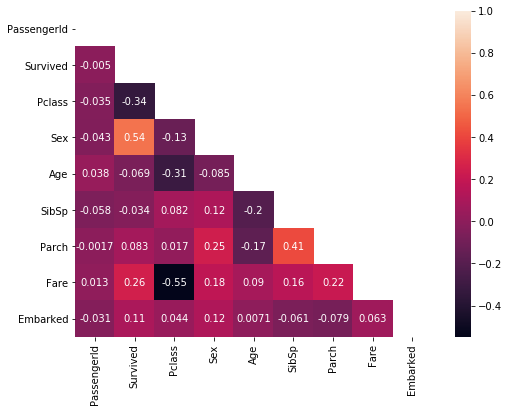

In [651]:
corr_matrix(total_dfm)